In [1]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs, max_new_tokens=50)
print(processor.decode(out[0], skip_special_tokens=True))


a woman sitting on the beach with her dog


laughing_fb80G5HM_t4_75.mp4


Video has 45 frames, we will sample every 9 frames
a group of people are playing with a cardboard box
a group of people walking around a table
a woman is sitting on a chair in the street
a man is sitting on a chair in the street
a man is sitting on a chair in the middle of a yard


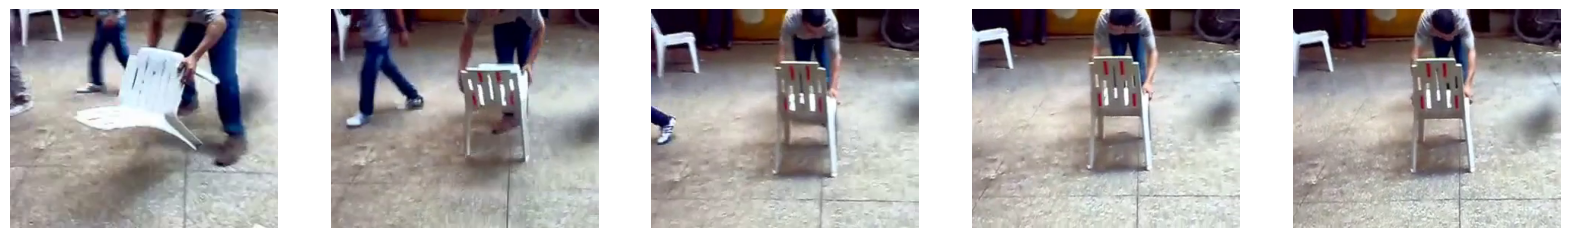

In [2]:
# Open a random video from the memento folder, sample 5 frames (equally distributed over time) and generate captions for each frame
DATA_FOLDER = "/home/imartinf/Memento10k/videos/"

import os
import random

videos = os.listdir(DATA_FOLDER)
video = random.choice(videos)
video = video if video.endswith(".mp4") else video + ".mp4"
print(video)

import cv2
import math

cap = cv2.VideoCapture(DATA_FOLDER + video)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_step = math.ceil(frame_count / 5)
print(f"Video has {frame_count} frames, we will sample every {frame_step} frames")
frames = []
for i in range(0, frame_count, frame_step):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
cap.release()

# Show the frames
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(frames), figsize=(20, 20))
for i, frame in enumerate(frames):
    axs[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')

# Use the model with the frames in a batch
inputs = processor(frames, return_tensors="pt").to("cuda")
out = model.generate(**inputs, max_new_tokens=100)
for i in range(len(frames)):
    print(processor.decode(out[i], skip_special_tokens=True))


In [3]:
import pandas as pd
import numpy as np

PD_PATH = "/home/imartinf/Memento10k/"
train = pd.read_json(PD_PATH + "memento_train_data.json")
val = pd.read_json(PD_PATH + "memento_val_data.json")

df = pd.concat([train, val], ignore_index=True)
df.head()

,filename,url,mem_score,alpha,audio_description,captions,action_labels
0,adult-female-singing_peeks-www_k_to_keek_2Qwue...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,[A brown hair girl with lip piercings mumbles ...,"[holding, looking, adult+female+singing, singing]"
1,adult-female-singing_peeks-www_k_to_keek_2Xyqe...,https://data.csail.mit.edu/soundnet/actions3/a...,0.913391,0.000410,owner of short brown hair wearing a blue sweat...,[A woman is standing and singing under a ceili...,"[adult+female+singing, standing, singing]"
2,adult-female-singing_peeks-www_k_to_keek_2g4te...,https://data.csail.mit.edu/soundnet/actions3/a...,0.932910,-0.000518,videos of lady face up close and she's singing...,[A person wearing a white sleeveless shirt is ...,"[dancing, adult+female+singing, speaking, sing..."
3,adult-female-singing_peeks-www_k_to_keek_EO30e...,https://data.csail.mit.edu/soundnet/actions3/a...,0.966062,-0.000108,videos of the lady on the red wall and she's d...,"[A woman leans against a red, decorated wall a...","[dancing, cheering, adult+female+singing, sing..."
4,adult-female-singing_peeks-www_k_to_keek_J2Rve...,https://data.csail.mit.edu/soundnet/actions3/a...,0.944808,-0.000662,this is a video of a woman in a red shirt and ...,[Two overweight women sway next to each other ...,"[singing, adult+female+singing, standing]"


In [4]:
from tqdm import tqdm


df['filename'] = df['filename'].apply(lambda x: os.path.join(DATA_FOLDER, x))
frames = dict()
for video in tqdm(df['filename'].values, desc="Reading videos", total=len(df)):
    # Get the middle frame for each video
    frames_path = video.replace(".mp4", "")
    frames_path = os.path.join(frames_path, "frames")
    # The frames folder contains all frames separately, choose the middle one
    middle_frame_path = os.path.join(frames_path, os.listdir(frames_path)[len(os.listdir(frames_path)) // 2])
    # print(middle_frame_path)
    frames[video] = cv2.imread(middle_frame_path)

Reading videos: 100%|██████████| 8500/8500 [02:44<00:00, 51.57it/s] 


In [5]:
# Get automatic captions for whole dataset (in batches)
captions = []
bsize = 64
for i in tqdm(range(0, len(df), bsize), desc="Generating captions", total=len(df) // bsize):
    batch = df.iloc[i:i+bsize]
    inputs = processor([frames[video] for video in batch['filename'].values], return_tensors="pt").to("cuda")
    out = model.generate(**inputs, max_new_tokens=100)
    captions.extend([processor.decode(out[i], skip_special_tokens=True) for i in range(len(batch))])

# Add captions to dataframe
df['blip_caption'] = captions
df.head()

Generating captions: 133it [02:57,  1.34s/it]                         


,filename,url,mem_score,alpha,audio_description,captions,action_labels,blip_caption
0,/home/imartinf/Memento10k/videos/adult-female-...,https://data.csail.mit.edu/soundnet/actions3/a...,0.989151,-0.000387,indoors you see a woman with red hair held up ...,[A brown hair girl with lip piercings mumbles ...,"[holding, looking, adult+female+singing, singing]",a woman with blue paint on her face
1,/home/imartinf/Memento10k/videos/adult-female-...,https://data.csail.mit.edu/soundnet/actions3/a...,0.913391,0.000410,owner of short brown hair wearing a blue sweat...,[A woman is standing and singing under a ceili...,"[adult+female+singing, standing, singing]",a man in a room
2,/home/imartinf/Memento10k/videos/adult-female-...,https://data.csail.mit.edu/soundnet/actions3/a...,0.932910,-0.000518,videos of lady face up close and she's singing...,[A person wearing a white sleeveless shirt is ...,"[dancing, adult+female+singing, speaking, sing...",a man sitting at a table with a laptop
3,/home/imartinf/Memento10k/videos/adult-female-...,https://data.csail.mit.edu/soundnet/actions3/a...,0.966062,-0.000108,videos of the lady on the red wall and she's d...,"[A woman leans against a red, decorated wall a...","[dancing, cheering, adult+female+singing, sing...",a woman standing in a room with a blue wall
4,/home/imartinf/Memento10k/videos/adult-female-...,https://data.csail.mit.edu/soundnet/actions3/a...,0.944808,-0.000662,this is a video of a woman in a red shirt and ...,[Two overweight women sway next to each other ...,"[singing, adult+female+singing, standing]",two women are standing in a room with a ceilin...


In [ ]:
os.makedirs("/home/imartinf/multimemo/data", exist_ok=True)
os.makedirs("/home/imartinf/multimemo/data/processed", exist_ok=True)
df['filename'] = df['filename'].apply(lambda x: x.replace(DATA_FOLDER, ""))
df.to_json("/home/imartinf/multimemo/data/processed/memento_blip_captions.json", orient="records")